# CDOM Spectral Slope Processing using Mannino et al. Algorithm

This notebook demonstrates an end-to-end pipeline for processing satellite L2 RRS data to derive, interpolate, and plot CDOM spectral slope using the Mannino et al. Multiple Linear Regression (MLR) algorithm. It performs the following steps:

1.  **Import libraries** and set up the environment.
2.  **Define constants** for CDOM spectral slope calculation using Mannino et al. coefficients, bounding box, and binning.
3.  **Search for and load** the satellite L2 RRS NetCDF files.
4.  **Inspect RRS data** to confirm variable names (specifically Rrs_443 and Rrs_547).
5.  **Extract RRS data on a GPU** using CuPy and parallel processing via `l2_pipeline`.
6.  **Calculate CDOM spectral slope** using the Mannino et al. MLR algorithm with Rrs(443) and Rrs(547).
7.  **Clip, bin, and apply selective NaN interpolation** to the CDOM spectral slope data.
8.  **Plot** the rasterized and interpolated CDOM spectral slope using the cmocean matter colormap.

**Algorithm Reference:** 
Mannino, A., et al. "Algorithm development and validation for satellite-derived distributions of DOC and CDOM in the U.S. Middle Atlantic Bight."

**Available Spectral Slopes:**
- **S_275:295**: Ln[S_275:295] = -3.258 + 0.336 × Ln[Rrs(443)] - 0.279 × Ln[Rrs(547)]
- **S_300:600**: Ln[S_300:600] = -3.640 + 0.186 × Ln[Rrs(443)] - 0.146 × Ln[Rrs(547)]

### Library Imports

The following cell imports essential libraries required for file handling, numerical operations, plotting, and the custom processing pipeline. Note the addition of cmocean for the matter colormap.

In [ ]:
# Import essential libraries
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d
import xarray as xr # For inspecting NetCDF variables
import cmocean  # For oceanographic colormaps, specifically the matter colormap

import sys
sys.dont_write_bytecode = True
sys.path.append(os.path.abspath(".."))  # adds project_root to path

# Import custom pipeline components
import importlib
from pipelines import l2_pipeline # Import the module itself to reload
importlib.reload(l2_pipeline)
from pipelines.l2_pipeline import L2DatasetLoader, GPUDataExtractor, SelectiveInterpolator

# Suppress RuntimeWarnings that can occur with NaNs in calculations, e.g. log(0)
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

### Define Constants and Parameters

This cell defines constants for the CDOM spectral slope calculation using the Mannino et al. algorithm, the geographical area of interest (bounding box), and parameters for binning the data. The Mannino et al. algorithm uses Multiple Linear Regression (MLR) to retrieve CDOM spectral slopes from remote sensing reflectance data at 443 nm and 547 nm wavelengths.

In [24]:
# CDOM Spectral Slope Calculation Constants using Mannino et al. Algorithm
# Wavelengths for spectral slope calculation (in nm) - Only 443 and 547 needed for MLR
WAVELENGTHS = np.array([443, 547])  # Required wavelengths for Mannino et al. algorithm

# MLR Coefficients for S_275:295 (using Rrs_443 and Rrs_547)
# Ln[S_275:295] = -3.258 + 0.336 × Ln[Rrs(443)] - 0.279 × Ln[Rrs(547)]
S275_295_COEFFS = {
    'B0': -3.258,    # Constant
    'B1': 0.336,     # Coefficient for Ln[Rrs(443)]
    'B2': -0.279     # Coefficient for Ln[Rrs(547)]
}

# MLR Coefficients for S_300:600 (using Rrs_443 and Rrs_547)
# Ln[S_300:600] = -3.640 + 0.186 × Ln[Rrs(443)] - 0.146 × Ln[Rrs(547)]
S300_600_COEFFS = {
    'B0': -3.640,    # Constant
    'B1': 0.186,     # Coefficient for Ln[Rrs(443)]
    'B2': -0.146     # Coefficient for Ln[Rrs(547)]
}

# Select which spectral slope to calculate ('S275_295' or 'S300_600')
SLOPE_TYPE = 'S275_295'  # Change this to 'S300_600' if you want the other slope

# Geographical Bounding Box
lon_min, lon_max = -94.0, -88.0
lat_min, lat_max = 27.5, 30.5

# Binning parameters
lat_bins = 200 # tall
lon_bins = 300 # wide

# L2 RRS Data Configuration
# Directory for L2 RRS NetCDF files. These files are expected to have variables in a 'geophysical_data' group.
data_dir_l2_rrs = r"E:\satdata\Texas Louisiana Shelf_2024-06-01_2024-06-30" # Update this path
# Variables for Remote Sensing Reflectance needed for CDOM spectral slope calculation (Mannino et al.)
rrs_vars_list = ['Rrs_443', 'Rrs_547']  # Only these two wavelengths are needed
# Default group for L2 RRS data in NetCDF files
rrs_data_group = 'geophysical_data'

### Searching for L2 RRS Data Files

Specify the directory containing the L2 RRS NetCDF satellite data files and search for them.

In [25]:
# Specify the data directory for L2 RRS and search recursively for NetCDF files
# IMPORTANT: Update this path to your actual L2 RRS data directory.
# data_dir_l2_rrs is defined in the previous cell
nc_files_rrs = glob.glob(os.path.join(data_dir_l2_rrs, '**', '*.nc'), recursive=True)

if not nc_files_rrs:
    print(f"Warning: No .nc files found for L2 RRS in {data_dir_l2_rrs}. Please check the path and data.")
else:
    print(f"Found {len(nc_files_rrs)} L2 RRS files.")

# Limiting files for quick testing, remove or adjust as needed for RRS
# nc_files_rrs = nc_files_rrs[:5]
# print(f"Using {len(nc_files_rrs)} L2 RRS files for processing.")

Found 42 L2 RRS files.


### Filter Files to One Week Period

This cell filters the found NetCDF files to only include data from a specific week. Modify the `target_week_start` date to select different weeks within your data period.

In [26]:
# Filter files to show only one week of data
from datetime import datetime, timedelta
import re

# Define the target week (modify this date to select different weeks)
target_week_start = "2024-06-01"  # Start of the week you want to analyze (YYYY-MM-DD)
week_start = datetime.strptime(target_week_start, "%Y-%m-%d")
week_end = week_start + timedelta(days=7)

print(f"Filtering files for week: {week_start.strftime('%Y-%m-%d')} to {week_end.strftime('%Y-%m-%d')}")

# Function to extract date from filename
def extract_date_from_filename(filename):
    """Extract date from satellite filename patterns"""
    # Common patterns in satellite filenames (adjust if your filenames differ)
    patterns = [
        r'(\d{4})(\d{2})(\d{2})',  # YYYYMMDD
        r'(\d{4})-(\d{2})-(\d{2})',  # YYYY-MM-DD
        r'(\d{4})(\d{3})',  # YYYYDDD (year + day of year)
    ]
    
    basename = os.path.basename(filename)
    
    for pattern in patterns:
        match = re.search(pattern, basename)
        if match:
            try:
                if len(match.groups()) == 3:  # YYYY MM DD format
                    year, month, day = map(int, match.groups())
                    return datetime(year, month, day)
                elif len(match.groups()) == 2:  # YYYY DDD format (day of year)
                    year, day_of_year = map(int, match.groups())
                    return datetime(year, 1, 1) + timedelta(days=day_of_year - 1)
            except ValueError:
                continue
    return None

# Filter files by date
weekly_nc_files_rrs = []
files_with_dates = 0

for file_path in nc_files_rrs:
    file_date = extract_date_from_filename(file_path)
    if file_date:
        files_with_dates += 1
        if week_start <= file_date < week_end:
            weekly_nc_files_rrs.append(file_path)

print(f"Found dates in {files_with_dates} out of {len(nc_files_rrs)} files")
print(f"Filtered to {len(weekly_nc_files_rrs)} files for the target week")

if weekly_nc_files_rrs:
    # Replace the original file list with the weekly filtered list
    nc_files_rrs = weekly_nc_files_rrs
    print(f"Using {len(nc_files_rrs)} files for weekly CDOM spectral slope analysis")
else:
    print(f"Warning: No files found for the week {target_week_start}. Using all available files.")
    print("Consider adjusting the target_week_start date or check if your filename format matches the extraction patterns.")

Filtering files for week: 2024-06-01 to 2024-06-08
Found dates in 42 out of 42 files
Filtered to 11 files for the target week
Using 11 files for weekly CDOM spectral slope analysis


### Inspecting Variables in the RRS Data

The following cell loads the first L2 RRS NetCDF file found and prints its variables, particularly within the expected `geophysical_data` group. Please use this information to:

1.  Confirm the correct variable names for Remote Sensing Reflectance (specifically 'Rrs_443' and 'Rrs_547' needed for Mannino et al. algorithm).
2.  Update the `rrs_vars_list` and `rrs_data_group` in the constants cell if the current values are incorrect for your RRS data.

In [27]:
if nc_files_rrs:
    print(f"Inspecting variables in the first L2 RRS file: {nc_files_rrs[0]}")
    try:
        with xr.open_dataset(nc_files_rrs[0], group=rrs_data_group) as ds_geo:
            print(f"\nVariables in group: '{rrs_data_group}'")
            for var_name_ds in ds_geo.variables:
                print(f"  {var_name_ds}: {ds_geo[var_name_ds].dims} – {ds_geo[var_name_ds].shape} - Attributes: {ds_geo[var_name_ds].attrs}")
            
            found_rrs_vars = list(ds_geo.variables)
            missing_vars = [var for var in rrs_vars_list if var not in found_rrs_vars]
            if not missing_vars:
                print(f"\nAll required RRS variables ({rrs_vars_list}) found in group '{rrs_data_group}'.")
            else:
                print(f"\nWARNING: The following RRS variables were NOT found in group '{rrs_data_group}': {missing_vars}.")
                print(f"  Available variables in group '{rrs_data_group}': {found_rrs_vars}")
                print(f"  Please check `rrs_vars_list` and `rrs_data_group` in the constants cell.")
        
        # Also check navigation data, typically in 'navigation_data' or root
        try:
            with xr.open_dataset(nc_files_rrs[0], group='navigation_data') as ds_nav:
                 print(f"\nVariables in group: 'navigation_data'")
                 for var_name_ds in ds_nav.variables:
                    print(f"  {var_name_ds}: {ds_nav[var_name_ds].dims} – {ds_nav[var_name_ds].shape} - Attributes: {ds_nav[var_name_ds].attrs}")
        except Exception:
            print("\nCould not open or inspect 'navigation_data' group. Latitude/longitude might be in the root or another group.")
            try:
                with xr.open_dataset(nc_files_rrs[0]) as ds_root:
                    print(f"\nVariables in root group:")
                    for var_name_ds in ds_root.variables:
                        print(f"  {var_name_ds}: {ds_root[var_name_ds].dims} – {ds_root[var_name_ds].shape} - Attributes: {ds_root[var_name_ds].attrs}")
            except Exception as e_root:
                 print(f"Could not open or inspect root group: {e_root}")


    except Exception as e:
        print(f"Error inspecting file {nc_files_rrs[0]} (group '{rrs_data_group}'): {e}")
        print(f"Ensure `rrs_data_group` (currently '{rrs_data_group}') is correct for your L2 RRS files.")
else:
    print("No L2 RRS NetCDF files found to inspect. Cannot verify RRS variable names or coordinates.")

Inspecting variables in the first L2 RRS file: E:\satdata\Texas Louisiana Shelf_2024-06-01_2024-06-30\AQUA_MODIS.20240601T191500.L2.OC.nc

Variables in group: 'geophysical_data'
  aot_869: ('number_of_lines', 'pixels_per_line') – (2030, 1354) - Attributes: {'long_name': 'Aerosol optical thickness at 869 nm', 'standard_name': 'atmosphere_optical_thickness_due_to_ambient_aerosol', 'valid_min': np.int16(0), 'valid_max': np.int16(30000)}
  angstrom: ('number_of_lines', 'pixels_per_line') – (2030, 1354) - Attributes: {'long_name': 'Aerosol Angstrom exponent, 443 to 865 nm', 'standard_name': 'aerosol_angstrom_exponent', 'valid_min': np.int16(-30000), 'valid_max': np.int16(5000)}
  Rrs_412: ('number_of_lines', 'pixels_per_line') – (2030, 1354) - Attributes: {'long_name': 'Remote sensing reflectance at 412 nm', 'units': 'sr^-1', 'standard_name': 'surface_ratio_of_upwelling_radiance_emerging_from_sea_water_to_downwelling_radiative_flux_in_air', 'valid_min': np.int16(-30000), 'valid_max': np.int

### Loading L2 RRS Datasets

Using `L2DatasetLoader`, this cell loads L2 RRS datasets. It assumes variables are in the `geophysical_data` group by default (or as specified in `rrs_data_group`).

In [28]:
# Load L2 RRS datasets
datasets_rrs = []
if nc_files_rrs:
    try:
        # Pass the rrs_data_group to the loader.
        # L2DatasetLoader's default for 'group' is 'geophysical_data', so this might be redundant if default is used.
        loader_rrs = L2DatasetLoader(variables=rrs_vars_list, group=rrs_data_group) 
        datasets_rrs = loader_rrs.load_multiple(nc_files_rrs)
        print(f"Successfully loaded {len(datasets_rrs)} L2 RRS datasets.")
    except Exception as e:
        print(f"Error loading L2 RRS datasets: {e}")
else:
    print("No L2 RRS files found to load.")

# Initialize placeholder variables for extracted data
lon_rrs_flat, lat_rrs_flat, rrs_vars_data_flat = np.array([]), np.array([]), {var: np.array([]) for var in rrs_vars_list}

Successfully loaded 11 L2 RRS datasets.


### GPU Data Extraction for L2 RRS

This cell leverages the GPU (if available and CuPy is installed) via `GPUDataExtractor` to extract and filter latitude, longitude, and RRS variable data from the loaded L2 RRS datasets.

In [29]:
# Extract L2 RRS data
if datasets_rrs:
    try:
        extractor_rrs = GPUDataExtractor(variables=rrs_vars_list) # Assumes lat/lon are 'latitude'/'longitude'
        lon_rrs_flat, lat_rrs_flat, rrs_vars_data_flat = extractor_rrs.extract(datasets_rrs)
        print(f"L2 RRS data extraction complete. Extracted {len(lon_rrs_flat)} data points.")
        for var in rrs_vars_list:
            if var not in rrs_vars_data_flat or rrs_vars_data_flat[var].size == 0:
                 print(f"Warning: RRS variable '{var}' not found or empty in extracted L2 data.")
                 if var not in rrs_vars_data_flat: rrs_vars_data_flat[var] = np.array([]) # Ensure key exists
    except Exception as e:
        print(f"Error during L2 RRS data extraction: {e}")
        lon_rrs_flat, lat_rrs_flat, rrs_vars_data_flat = np.array([]), np.array([]), {var: np.array([]) for var in rrs_vars_list}
else:
    print("No L2 RRS datasets loaded, skipping L2 RRS data extraction.")
    lon_rrs_flat, lat_rrs_flat, rrs_vars_data_flat = np.array([]), np.array([]), {var: np.array([]) for var in rrs_vars_list}

L2 RRS data extraction complete. Extracted 3280805 data points.


### Data Processing: CDOM Spectral Slope Calculation using Mannino et al. Algorithm

This section processes the extracted RRS data to calculate CDOM spectral slope using the Mannino et al. Multiple Linear Regression (MLR) algorithm. The algorithm uses remote sensing reflectance at 443 nm and 547 nm to retrieve either S_275:295 or S_300:600 spectral slopes.

**Algorithm Details:**
- **S_275:295**: Ln[S_275:295] = -3.258 + 0.336 × Ln[Rrs(443)] - 0.279 × Ln[Rrs(547)]
- **S_300:600**: Ln[S_300:600] = -3.640 + 0.186 × Ln[Rrs(443)] - 0.146 × Ln[Rrs(547)]

The spectral slope is then obtained by taking the exponential of the result: S = exp(Ln[S]).

In [30]:
# Initialize final variables for processing
cdom_slope_values = np.array([])

# Perform calculations only if RRS data was extracted
if lon_rrs_flat.size > 0 and rrs_vars_data_flat:
    all_lon_rrs = lon_rrs_flat
    all_lat_rrs = lat_rrs_flat

    # --- CDOM Spectral Slope Calculation using Mannino et al. Algorithm ---
    # Extract the required RRS data (443 nm and 547 nm)
    rrs_443 = rrs_vars_data_flat.get('Rrs_443', np.array([]))
    rrs_547 = rrs_vars_data_flat.get('Rrs_547', np.array([]))
    
    # Check if both wavelengths are available and have correct shape
    if (rrs_443.size > 0 and rrs_547.size > 0 and 
        rrs_443.shape == all_lon_rrs.shape and rrs_547.shape == all_lon_rrs.shape):
        
        # Initialize slope values
        cdom_slope_values = np.full(all_lon_rrs.shape, np.nan)
        
        # Create mask for valid data (no NaNs and positive values)
        valid_mask = (~np.isnan(rrs_443) & ~np.isnan(rrs_547) & 
                     (rrs_443 > 0) & (rrs_547 > 0))
        
        if np.any(valid_mask):
            # Get the coefficients for the selected slope type
            if SLOPE_TYPE == 'S275_295':
                coeffs = S275_295_COEFFS
                slope_name = "S_275:295"
            elif SLOPE_TYPE == 'S300_600':
                coeffs = S300_600_COEFFS
                slope_name = "S_300:600"
            else:
                print(f"Error: Unknown slope type '{SLOPE_TYPE}'. Using S_275:295 as default.")
                coeffs = S275_295_COEFFS
                slope_name = "S_275:295"
            
            # Apply Mannino et al. MLR algorithm
            # Ln[S] = B0 + B1 × Ln[Rrs(443)] + B2 × Ln[Rrs(547)]
            ln_rrs_443 = np.log(rrs_443[valid_mask])
            ln_rrs_547 = np.log(rrs_547[valid_mask])
            
            ln_slope = (coeffs['B0'] + 
                       coeffs['B1'] * ln_rrs_443 + 
                       coeffs['B2'] * ln_rrs_547)
            
            # Convert back to linear space: S = exp(Ln[S])
            slope_values_valid = np.exp(ln_slope)
            
            # Assign back to the full array
            cdom_slope_values[valid_mask] = slope_values_valid
            
            print(f"CDOM spectral slope calculation complete using Mannino et al. algorithm for {slope_name}.")
            valid_slopes = cdom_slope_values[~np.isnan(cdom_slope_values)]
            if len(valid_slopes) > 0:
                print(f"Min slope: {np.min(valid_slopes):.6f} nm⁻¹, Max slope: {np.max(valid_slopes):.6f} nm⁻¹")
                print(f"Mean slope: {np.mean(valid_slopes):.6f} nm⁻¹, Std: {np.std(valid_slopes):.6f} nm⁻¹")
            else:
                print("CDOM spectral slope calculation resulted in all NaNs.")
        else:
            print("No valid data points found for CDOM spectral slope calculation.")
    else:
        missing_vars = []
        if rrs_443.size == 0: missing_vars.append('Rrs_443')
        if rrs_547.size == 0: missing_vars.append('Rrs_547')
        if missing_vars:
            print(f"Skipping CDOM spectral slope calculation: Missing variables {missing_vars}")
        else:
            print("Skipping CDOM spectral slope calculation: Shape mismatch in RRS data.")

    # Filter data for CDOM spectral slope
    valid_rrs_mask = ~np.isnan(all_lon_rrs) & ~np.isnan(all_lat_rrs) & ~np.isnan(cdom_slope_values)
    final_lon_rrs = all_lon_rrs[valid_rrs_mask]
    final_lat_rrs = all_lat_rrs[valid_rrs_mask]
    final_cdom_slope_rrs = cdom_slope_values[valid_rrs_mask]
    print(f"Filtered NaNs for CDOM spectral slope data, {len(final_lon_rrs)} valid data points remaining for binning.")

else:
    print("Skipping CDOM spectral slope data processing: No L2 RRS data extracted or available.")
    final_lon_rrs, final_lat_rrs, final_cdom_slope_rrs = np.array([]), np.array([]), np.array([])

CDOM spectral slope calculation complete using Mannino et al. algorithm for S_275:295.
Min slope: 0.002002 nm⁻¹, Max slope: 0.267514 nm⁻¹
Mean slope: 0.041646 nm⁻¹, Std: 0.008427 nm⁻¹
Filtered NaNs for CDOM spectral slope data, 3267255 valid data points remaining for binning.
Filtered NaNs for CDOM spectral slope data, 3267255 valid data points remaining for binning.


### Clipping and Binning CDOM Spectral Slope Data

The extracted and processed CDOM spectral slope data points are now clipped to the defined geographical bounding box. Then, a 2D binned statistic (mean) is computed for CDOM spectral slope.

In [31]:
# Initialize binned data variables
binned_cdom_slope = np.array([[]])
lon_grid, lat_grid = None, None
lat_edges, lon_edges = None, None # Store edges for interpolation and plotting

# Binning for CDOM Spectral Slope
if final_lon_rrs.size > 0:
    clip_mask_rrs = (
        (final_lon_rrs >= lon_min) & (final_lon_rrs <= lon_max) &
        (final_lat_rrs >= lat_min) & (final_lat_rrs <= lat_max)
    )
    clipped_lon_rrs = final_lon_rrs[clip_mask_rrs]
    clipped_lat_rrs = final_lat_rrs[clip_mask_rrs]
    clipped_cdom_slope_rrs = final_cdom_slope_rrs[clip_mask_rrs]
    print(f"Clipped CDOM spectral slope data to bounding box. {len(clipped_lon_rrs)} points remaining.")

    if clipped_lon_rrs.size > 0:
        binned_cdom_slope, lat_edges_temp, lon_edges_temp, _ = binned_statistic_2d(
            clipped_lat_rrs, clipped_lon_rrs, clipped_cdom_slope_rrs,
            statistic='mean', bins=[lat_bins, lon_bins], range=[[lat_min, lat_max], [lon_min, lon_max]]
        )
        # Store edges (binned_statistic_2d returns bin edges, pcolormesh needs these)
        lat_edges = lat_edges_temp
        lon_edges = lon_edges_temp
        
        print("2D binning complete for CDOM spectral slope.")
        # Create meshgrid for potential other plot types or analysis, though pcolormesh uses edges
        lon_grid, lat_grid = np.meshgrid(lon_edges_temp[:-1] + np.diff(lon_edges_temp)/2, 
                                         lat_edges_temp[:-1] + np.diff(lat_edges_temp)/2) # Bin centers
    else:
        print("No CDOM spectral slope data points within the bounding box to bin.")
else:
    print("No valid CDOM spectral slope data to clip or bin.")

if lat_edges is None or lon_edges is None:
    print("Warning: CDOM spectral slope grid edges (lat_edges, lon_edges) not created. Interpolation/Plotting might fail.")

Clipped CDOM spectral slope data to bounding box. 155309 points remaining.
2D binning complete for CDOM spectral slope.


### Selective NaN Interpolation for CDOM Spectral Slope

This section demonstrates using the `SelectiveInterpolator` to fill small gaps (NaNs) in the binned CDOM spectral slope data, potentially improving visual continuity while preserving larger NaN regions.

In [32]:
# Initialize interpolated data variable
cdom_slope_selective_interp = np.array([[]])
interpolation_threshold = 128  # Regions with fewer connected NaN bins than this will be interpolated

# Interpolation for CDOM Spectral Slope
if 'binned_cdom_slope' in locals() and binned_cdom_slope.shape[0] > 0 and binned_cdom_slope.shape[1] > 0 and lat_edges is not None and lon_edges is not None:
    cdom_slope_selective_interp = SelectiveInterpolator.interpolate(
        binned_cdom_slope, lat_edges, lon_edges, threshold=interpolation_threshold # Pass 1D edges
    )
    print(f"Selective NaN interpolation complete for CDOM spectral slope (threshold: {interpolation_threshold} bins).")
else:
    print("No binned CDOM spectral slope data available for selective interpolation, or grid edges not available.")

Selective NaN interpolation complete for CDOM spectral slope (threshold: 128 bins).


### Plotting Interpolated CDOM Spectral Slope

The binned and selectively interpolated CDOM spectral slope data (calculated using the Mannino et al. MLR algorithm) is visualized on a map using Matplotlib and Cartopy with the cmocean matter colormap, which is specifically designed for oceanographic data visualization.

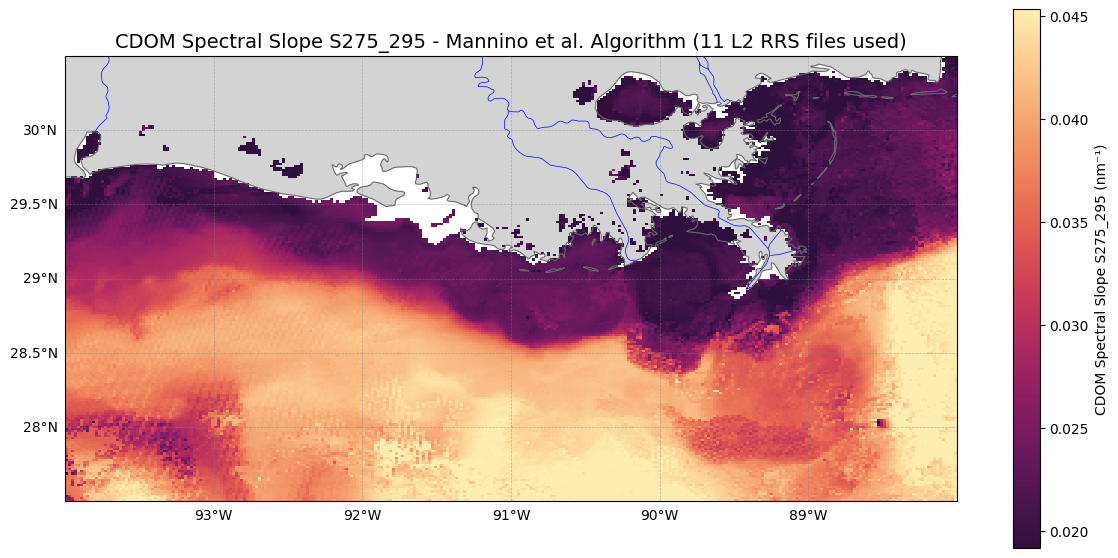

In [40]:
if 'cdom_slope_selective_interp' in locals() and cdom_slope_selective_interp.shape[0] > 0 and cdom_slope_selective_interp.shape[1] > 0 and lon_edges is not None and lat_edges is not None:
    fig_cdom_slope = plt.figure(figsize=(12,8))
    ax_cdom_slope = plt.axes(projection=ccrs.PlateCarree())
    ax_cdom_slope.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    valid_cdom_slope_values = cdom_slope_selective_interp[~np.isnan(cdom_slope_selective_interp)]
    if valid_cdom_slope_values.size > 0:
        vmin_cdom_slope = np.percentile(valid_cdom_slope_values, 5)
        vmax_cdom_slope = np.percentile(valid_cdom_slope_values, 95)
        if vmin_cdom_slope >= vmax_cdom_slope: # Handle cases with low variance
            vmin_cdom_slope = np.nanmin(valid_cdom_slope_values)
            vmax_cdom_slope = np.nanmax(valid_cdom_slope_values)
        if vmin_cdom_slope == vmax_cdom_slope: # Handle cases where all valid values are the same
            vmin_cdom_slope -= 0.001 
            vmax_cdom_slope += 0.001
        if np.isnan(vmin_cdom_slope) or np.isnan(vmax_cdom_slope): # Fallback if percentiles result in NaN
            vmin_cdom_slope = -0.01 
            vmax_cdom_slope = 0.01
    else: # Fallback if no valid data
        vmin_cdom_slope = -0.01 
        vmax_cdom_slope = 0.01 

    # Use lon_edges and lat_edges for pcolormesh with cmocean matter colormap
    # The dimensions of cdom_slope_selective_interp should be (len(lat_edges)-1, len(lon_edges)-1)
    raster_cdom_slope = ax_cdom_slope.pcolormesh(
        lon_edges, lat_edges, cdom_slope_selective_interp,
        cmap=cmocean.cm.matter_r, shading='auto', 
        transform=ccrs.PlateCarree(),
        vmin=vmin_cdom_slope, vmax=vmax_cdom_slope
    )

    # Add map features
    ax_cdom_slope.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='dimGray')
    ax_cdom_slope.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
    ax_cdom_slope.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimGray')
    ax_cdom_slope.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue')

    # Add gridlines
    gl_cdom_slope = ax_cdom_slope.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                            linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl_cdom_slope.top_labels = False
    gl_cdom_slope.right_labels = False
    
    plt.colorbar(raster_cdom_slope, label=f'CDOM Spectral Slope {SLOPE_TYPE.replace("_", "_")} (nm⁻¹)', shrink=0.7)
    num_files_processed = len(nc_files_rrs) if 'nc_files_rrs' in locals() and nc_files_rrs is not None else 0
    plt.title(f"CDOM Spectral Slope {SLOPE_TYPE.replace('_', '_')} - Mannino et al. Algorithm ({num_files_processed} L2 RRS files used)", fontsize=14)
    
    plt.tight_layout()
    plt.show()
else:
    print("No selectively interpolated CDOM spectral slope data to plot or grid edges not available.")